Прогнозирование акций Лукойл

In [126]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from keras.optimizers import Adam #Оптимизатор
from keras.models import Sequential, Model #Два варианты моделей
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
import seaborn as sns
# Рисовать графики сразу же
%matplotlib inline

import os
print ("Ok")

Ok


In [127]:
#Загружаем датафрейм
frame = pd.read_csv('Gosloto_6x45_20200927.csv', header=0, sep=',')

In [128]:
# удвляем дату и тираж
frame = frame.drop(columns=['datetime', 'tiraz', 'jackpot'], axis=1).astype(float)

<AxesSubplot:>

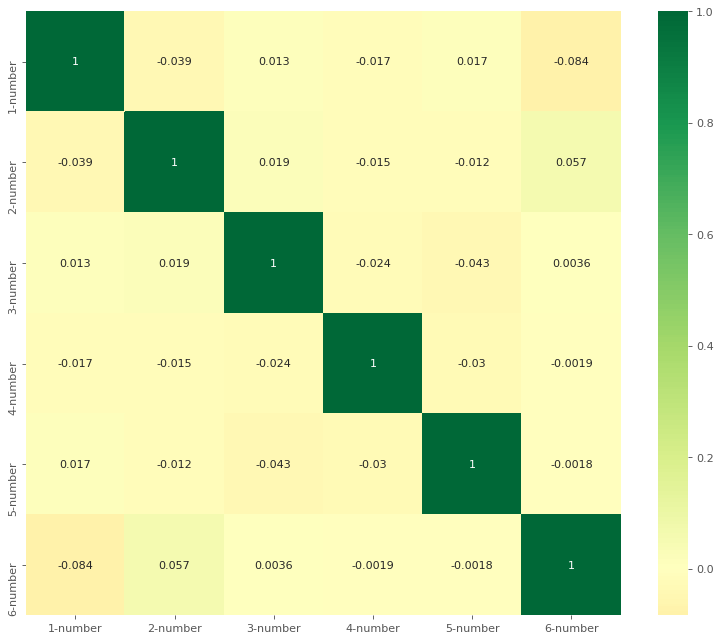

In [129]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(frame.corr(), xticklabels=frame.corr().columns, yticklabels=frame.corr().columns, cmap='RdYlGn', center=0, annot=True)

In [130]:
frame.describe()

,1-number,2-number,3-number,4-number,5-number,6-number
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,23.130000,23.134000,23.168000,22.832000,23.857000,22.525000
std,13.311961,12.988254,12.787545,13.265208,13.292752,12.701918
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000
50%,23.000000,23.000000,23.000000,23.000000,24.000000,22.000000
75%,35.000000,35.000000,34.000000,35.000000,36.000000,34.000000
max,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000


In [131]:
a = frame["1-number"].to_numpy()
b = frame["2-number"].to_numpy()
c = frame["3-number"].to_numpy()
d = frame["4-number"].to_numpy()
e = frame["5-number"].to_numpy()
f = frame["6-number"].to_numpy()
# for numa in a:
#     np.append(allnum, [numa])
con = np.stack([a, b, c,d,e,f], axis=1)
con_r = con.reshape(6000,)

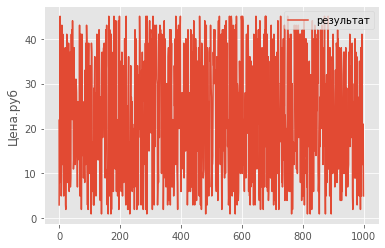

In [132]:
start = 0 #С какой точки начинаем
step = con_r.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
#chanelNames = list(allnum.columns)
plt.plot(con_r[0:1000],
          label="результат")
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

**Функция загрузки данных**

In [133]:
def DataNormalization(data, Channels, Normalization):
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()

  #Берём только те каналы, которые указаны в аргументе функции
  resData = data[:,Channels]
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)

  return (resData, scaler)

#Функция "раскусывания" данных для временных рядов
#data - данные
#xLen - размер фрема, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее
#если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#returnFlatten - делать ли одномерный вектор на выходе для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производнуюa
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):

  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T

  #Нормализуем x
  (xData, xScaler) = DataNormalization(data, xChannels, xNormalization)

  #Нормализуем y
  (yData, yScaler) = DataNormalization(data, yChannels, yNormalization)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(xData.shape[0] - xLen + 1 - stepsForward)])

  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 1):
    yTrain = np.array([yData[i:i + stepsForward, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])
  else:
    yTrain = np.array([yData[i, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])

  #Расчитываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]

  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [134]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
	predVal = yScaler.inverse_transform(currModel.predict(xVal))
	yValUnscaled = yScaler.inverse_transform(yVal)
	return (predVal, yValUnscaled)

#Функция расёта коэффициента корреляции Пирсона двух одномерных векторов
def correlate(a, b):
  return np.corrcoef(a, b)[0, 1]

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel],
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

In [135]:
#Функция строит корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    #Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      #Получаем сигнал, смещённый на i шагов назад
      #predVal[i:, ch]
      #Сравниваем его с верными ответами, без смещения назад
      #yValUnscaled[:yLen-i,ch]
      #Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    #Отображаем график корреляций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [176]:
#Формируем параметры загрузки данных
xLen = 6 #Анализируем по 300 прошедшим точкам
stepsForward = 1 #Предсказываем на 1 шаг вперёд
xChannels = range(con.shape[1]) #Используемвсе входные каналы
yChannels = [0] #Предказываем только open канал
xNormalization = 1 #Нормируем входные каналы стандартным распределением
yNormalization = 1#Нормируем выходные каналы стандартным распределением
valLen = 100 #Используем 30.000 записей для проверки0
returnFlatten = 0 #Вернуть одномерные вечеторы
convertToDerivative = 0 #Не превращать в производную

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = \
    getXTrainFromTimeSeries(con, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)


(873, 12, 6)
(873, 1)
(100, 12, 6)
(100, 1)


Epoch 1/20
25/25 [==============================] - 0s 4ms/step - loss: 0.8097 - val_loss: 0.5528
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4926 - val_loss: 0.3548
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.3532 - val_loss: 0.2848
Epoch 4/20
25/25 [==============================] - 0s 1ms/step - loss: 0.3070 - val_loss: 0.2653
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.2893 - val_loss: 0.2523
Epoch 6/20
25/25 [==============================] - 0s 2ms/step - loss: 0.2747 - val_loss: 0.2398
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.2605 - val_loss: 0.2275
Epoch 8/20
25/25 [================

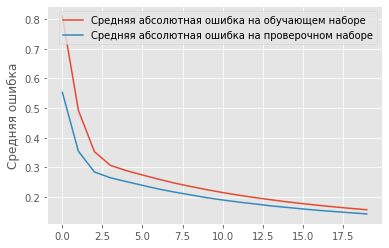

In [228]:
modelC = Sequential()
modelC.add(Conv1D(6, 6, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(24, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=36,
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [229]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)


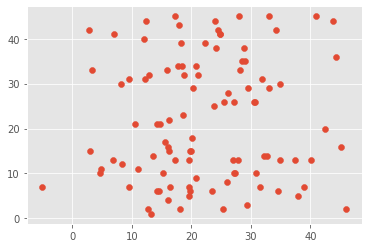

In [230]:
import matplotlib

matplotlib.style.use('ggplot')

#plt.figure(figsize=(12,12))
plt.scatter(predVal, yValUnscaled)
plt.show()

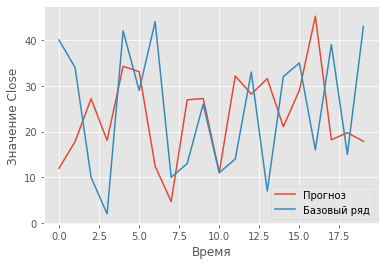

[[11.97336  ]
 [17.785088 ]
 [27.167225 ]
 [18.073616 ]
 [34.253353 ]
 [33.094707 ]
 [12.424928 ]
 [ 4.7038116]
 [26.930754 ]
 [27.224005 ]
 [11.081783 ]
 [32.13908  ]
 [28.174187 ]
 [31.567854 ]
 [21.062473 ]
 [28.973515 ]
 [45.197346 ]
 [18.197716 ]
 [19.748213 ]
 [17.858784 ]
 [16.034544 ]
 [30.579662 ]
 [19.91898  ]
 [40.96736  ]
 [ 6.8349843]
 [37.375637 ]
 [27.85527  ]
 [34.47411  ]
 [14.770423 ]
 [30.821272 ]
 [37.94792  ]
 [17.3027   ]
 [24.534988 ]
 [13.499461 ]
 [34.85264  ]
 [25.299839 ]
 [12.917235 ]
 [-5.11227  ]
 [23.721308 ]
 [28.512102 ]
 [20.800571 ]
 [ 9.44818  ]
 [33.114544 ]
 [20.254547 ]
 [20.821331 ]
 [ 7.0220194]
 [16.150259 ]
 [40.1488   ]
 [19.51793  ]
 [29.45821  ]
 [38.958775 ]
 [19.635063 ]
 [16.46393  ]
 [24.740265 ]
 [13.260731 ]
 [32.76863  ]
 [ 3.3632636]
 [24.008923 ]
 [28.863886 ]
 [14.183492 ]
 [ 9.56732  ]
 [14.277294 ]
 [ 8.158713 ]
 [26.057917 ]
 [18.575294 ]
 [28.062452 ]
 [29.429565 ]
 [30.69136  ]
 [14.626157 ]
 [43.823227 ]
 [15.990264 ]
 [ 2.8

In [231]:
#Отображаем графики
showPredict(0, 20, 0, predVal, yValUnscaled)
print (predVal, yValUnscaled)
print (yValUnscaled)


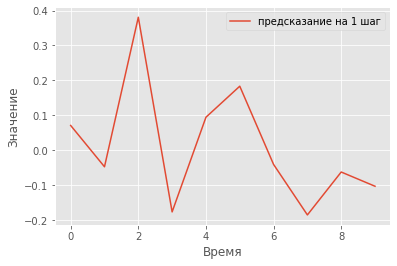

In [208]:
#Отображаем корреляцию

showCorr([0], 10, predVal, yValUnscaled)